# Testing Sparse Zero-Inflated Count Matrix Factorization in simulated data with SVI

In [1]:
from pCMF.misc import utils, plot_utils
from pCMF.models.pcmf.inferences import cavi_new, svi_new

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Experiment parameters
N = 100 # number of observations
P = 1000 # observation space dimensionality
K = 10 # latent space dimensionality
C = 3 # number of clusters

# Generate data set
z_p = 0.2
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_sparse_data(N, P, K, C=C, zero_prob=z_p, noisy_prop=0.5,
                                                 eps_U=eps, return_all=True)

Y_train, Y_test, X_train, X_test, D_train, D_test, U_train, U_test, c_train, c_test = train_test_split(Y, X, D, U.T, clusters, test_size=0.2, random_state=42)

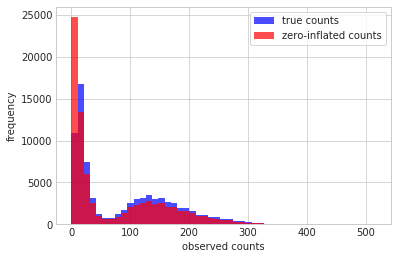

In [3]:
bins = np.linspace(0, X_train.max(), num=50)

plt.hist(X_train.flatten(), bins, alpha=0.7, label='true counts', color='blue')
plt.hist(Y_train.flatten(), bins, alpha=0.7, label='zero-inflated counts', color='red')
plt.xlabel('observed counts')
plt.ylabel('frequency')
plt.legend(frameon=True)
plt.show()

In [4]:
print("Training data:")
print("Number of true zero-counts: {0}".format(np.count_nonzero(X_train==0)))
print("Number of dropouts: {0}".format(np.count_nonzero(D_train==0)))

Training data:
Number of true zero-counts: 55
Number of dropouts: 16051


In [5]:
silhouette_score(Y_train, c_train)

0.03695047004185491

In [6]:
silhouette_score(U_train, c_train)

0.5128530914890168

In [7]:
T = 60. * 10.
S = 10.
max_iter = 1000000

In [8]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(Y_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [9]:
silhouette_score(pca_U, c_train)

0.06774142830410398

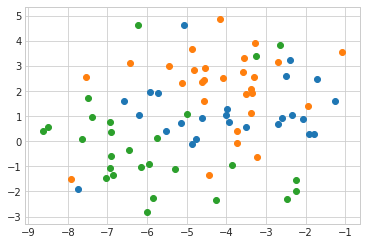

In [10]:
for c in range(C):
    plt.scatter(pca_tsne[c_train==c, 0], pca_tsne[c_train==c, 1])
plt.show()

In [11]:
# Prior parameters
alpha = np.abs(np.ones((2, K)) + np.random.rand(2, K))
beta = np.abs(np.ones((2, P, K)) + np.random.rand(2, P, K))
logit_pi_D = np.random.rand(P)
pi_D = np.exp(logit_pi_D) / (1. + np.exp(logit_pi_D))
logit_pi_S = np.random.rand(P)
pi_S = np.exp(logit_pi_S) / (1. + np.exp(logit_pi_S))

In [12]:
print('Simple GaP-EB:')
infgapeb = svi_new.StochasticVI(Y_train, alpha, beta, minibatch_size=10, empirical_bayes=True)
infgapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
gapeb_U = infgapeb.a[0] / infgapeb.a[1] # VI estimate is the mean of the variational approximation
gapeb_V = infgapeb.b[0] / infgapeb.b[1]
gapeb_D = infgapeb.estimate_D(infgapeb.p_D)
gapeb_S = infgapeb.estimate_S(infgapeb.p_S)
gapeb_tsne = TSNE(n_components=2).fit_transform(gapeb_U)

Simple GaP-EB:
Iteration 589/1000000. Log-likelihood: 207.951. Elapsed: 0h10m0s


In [13]:
print('Zero-Inflated GaP-EB:')
infzigapeb = svi_new.StochasticVI(Y_train, alpha, beta, pi_D=pi_D, minibatch_size=10, empirical_bayes=True)
infzigapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
zigapeb_U = infzigapeb.a[0] / infzigapeb.a[1] # VI estimate is the mean of the variational approximation
zigapeb_V = infzigapeb.b[0] / infzigapeb.b[1]
zigapeb_D = infzigapeb.estimate_D(infzigapeb.p_D)
zigapeb_S = infzigapeb.estimate_S(infzigapeb.p_S)
zigapeb_tsne = TSNE(n_components=2).fit_transform(zigapeb_U)

Zero-Inflated GaP-EB:
Considering zero-inflated counts.
Iteration 499/1000000. Log-likelihood: 201.667. Elapsed: 0h10m0s


In [14]:
print('Sparse Zero-Inflated GaP-EB:')
infszigapeb = svi_new.StochasticVI(Y_train, alpha, beta, pi_D=pi_D, pi_S=pi_S, minibatch_size=10, empirical_bayes=True)
infszigapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
szigapeb_U = infszigapeb.a[0] / infszigapeb.a[1] # VI estimate is the mean of the variational approximation
szigapeb_V = infszigapeb.b[0] / infszigapeb.b[1]
szigapeb_D = infszigapeb.estimate_D(infszigapeb.p_D)
szigapeb_S = infszigapeb.estimate_S(infszigapeb.p_S)
szigapeb_tsne = TSNE(n_components=2).fit_transform(szigapeb_U)

Sparse Zero-Inflated GaP-EB:
Considering zero-inflated counts.
Considering loading sparsity.
Iteration 395/1000000. Log-likelihood: 159.787. Elapsed: 0h10m1s


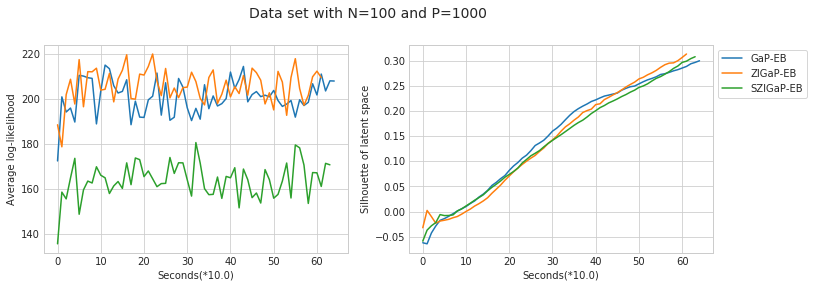

In [15]:
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(infgapeb.ll_time, label='GaP-EB')
ax.plot(infzigapeb.ll_time, label='ZIGaP-EB')
ax.plot(infszigapeb.ll_time, label='SZIGaP-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds(*{0})'.format(S))

ax = plt.subplot(1, 2, 2)
ax.plot(infgapeb.silh_time, label='GaP-EB')
ax.plot(infzigapeb.silh_time, label='ZIGaP-EB')
ax.plot(infszigapeb.silh_time, label='SZIGaP-EB')
plt.ylabel('Silhouette of latent space')
plt.xlabel('Seconds(*{0})'.format(S))

plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Data set with N={} and P={}'.format(N, P), fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()

In [16]:
gapeb_dll = utils.log_likelihood(Y_train, gapeb_U, gapeb_V, infgapeb.p_D, gapeb_S, clip=infgapeb.clip_ll)
zigapeb_dll = utils.log_likelihood(Y_train, zigapeb_U, zigapeb_V, infzigapeb.p_D, zigapeb_S, clip=infgapeb.clip_ll)
szigapeb_dll = utils.log_likelihood(Y_train, szigapeb_U, szigapeb_V, infszigapeb.p_D, szigapeb_S, clip=infgapeb.clip_ll)

scores = {'GaP-EB': gapeb_dll, 'ZIGaP-EB': zigapeb_dll, 'SZIGaP-EB': szigapeb_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.6}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.6}'.format(score_tp[0], score_tp[1]))

Full data log-likelihood:
- ZIGaP-EB: 2.07e+02
- GaP-EB: 2.03e+02
- SZIGaP-EB: 1.66e+02


In [17]:
gapeb_holl = infgapeb.predictive_ll(Y_test)
zigapeb_holl = infzigapeb.predictive_ll(Y_test)
szigapeb_holl = infszigapeb.predictive_ll(Y_test)

scores = {'GaP-EB': gapeb_holl, 'ZIGaP-EB': zigapeb_holl, 'SZIGaP-EB': szigapeb_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.6}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.6}'.format(score_tp[0], score_tp[1]))

Held-out log-likelihood:
- ZIGaP-EB: 2.09e+02
- GaP-EB: 2.05e+02
- SZIGaP-EB: 1.66e+02


In [18]:
true_silh = silhouette_score(U_train, c_train)
gapeb_silh = silhouette_score(gapeb_U, c_train)
zigapeb_silh = silhouette_score(zigapeb_U, c_train)
szigapeb_silh = silhouette_score(szigapeb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'GaP-EB': gapeb_silh, 'ZIGaP-EB': zigapeb_silh, 'SZIGaP-EB': szigapeb_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- ZIGaP-EB: 0.319
- SZIGaP-EB: 0.31
- GaP-EB: 0.3
- PCA: 0.0677

Silhouette of true U:
0.513


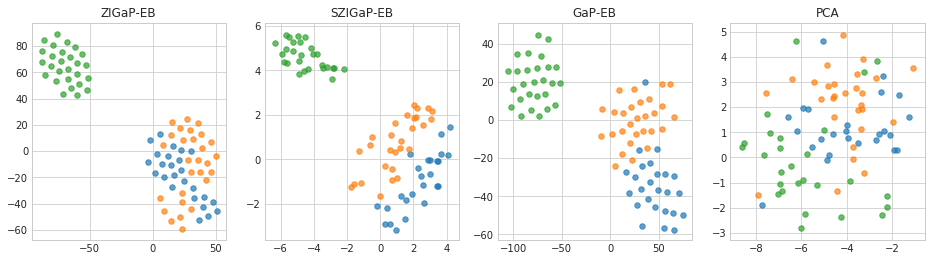

In [19]:
# Plot in decreasing silhouette order
U_list = [gapeb_tsne, zigapeb_tsne, szigapeb_tsne, pca_tsne]
title_list = ['GaP-EB', 'ZIGaP-EB', 'SZIGaP-EB', 'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(sorted_scores[i][0])
plt.show()

# Dropout identification and imputation
The held-out likelihood is only useful for data which isn't dominated by zeros. When it is, higher likelihoods will be obtained by models which place more mass at zero, which is not the comparison we want to make. In this case then, we evaluate the ability of the model to impute dropped out values.

We know what entries are dropouts because we have simulated them, and we also know the true value behind it.

First, we check if the model has identified dropouts well.

Then, we replace each dropout with the value the model finds to be most likely and compare it with the true value. For pCMF, imputing the entry $Y_{ij}$ corresponds to setting it to $U_iV_j $.

In [20]:
dropout_idx = np.where(D_train == 0)

## Dropout identification

In [21]:
gapeb_acc = accuracy_score(gapeb_D.flatten(), D_train.flatten())
zigapeb_acc = accuracy_score(zigapeb_D.flatten(), D_train.flatten())
szigapeb_acc = accuracy_score(szigapeb_D.flatten(), D_train.flatten())

scores = {'GaP-EB': gapeb_acc, 'ZIGaP-EB': zigapeb_acc, 'SZIGaP-EB': szigapeb_acc}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Dropout identification accuracy (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Dropout identification accuracy (higher is better):
- ZIGaP-EB: 0.994
- SZIGaP-EB: 0.955
- GaP-EB: 0.799


## Dropout imputation 

In [22]:
# Use the posterior Poisson mean
gapeb_R = np.dot(gapeb_U, gapeb_V.T)
zigapeb_R = np.dot(zigapeb_U, zigapeb_V.T)
szigapeb_R = np.dot(szigapeb_U, szigapeb_V.T)

In [23]:
# Compute the imputation error on the data entries we know to be dropouts
gapeb_err = utils.imputation_error(X_train, gapeb_R, dropout_idx)
zigapeb_err = utils.imputation_error(X_train, zigapeb_R, dropout_idx)
szigapeb_err = utils.imputation_error(X_train, szigapeb_R, dropout_idx)

scores = {'GaP-EB': gapeb_err, 'ZIGaP-EB': zigapeb_err, 'SZIGaP-EB': szigapeb_err}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=False)

print('Dropout imputation error (lower is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Dropout imputation error (lower is better):
- ZIGaP-EB: 8.52
- GaP-EB: 10.9
- SZIGaP-EB: 49.7


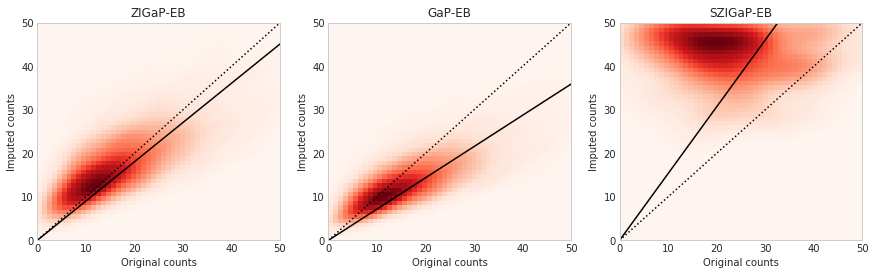

In [24]:
R_list = [gapeb_R, zigapeb_R, szigapeb_R]
title_list = ['GaP-EB', 'ZIGaP-EB', 'SZIGaP-EB']

fig = plt.figure(figsize=(20, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(R_list)):
    ax = plt.subplot(1, n_results, i+1)
    plot_utils.plot_imputation_density(
        R_list[title_list.index(sorted_scores[i][0])], X_train, dropout_idx, ymax=50, 
        ax=ax, title=sorted_scores[i][0])
plt.show()